# Generate synthetic lightcurves
Sample from parameters of all 78 Gaussian Processes to generate synthetic lightcurves.


Add uncorrelated noise by:
   - Fit GP to each lightcurve
   - Define distribution over GP parameters
   - Create histogram of residuals (how many of each amplitude)
   - Define cutoff as 3 sigma
   - Add all cutoff 'tails' to create an 'average' noise distribution

In [2]:
# imports
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import gpytorch
import matplotlib.pyplot as plt
import scipy.stats

from dipper.data_utils.utils import *
from dipper.model_utils.gp_model import *
from sklearn.mixture import GaussianMixture
from gpytorch.means import ConstantMean
from gpytorch.kernels import Kernel, PeriodicKernel, RBFKernel, ScaleKernel, ProductKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval, Positive, GreaterThan

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Single lightcurve

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:189: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


Dominant period: 0.8931992337164751


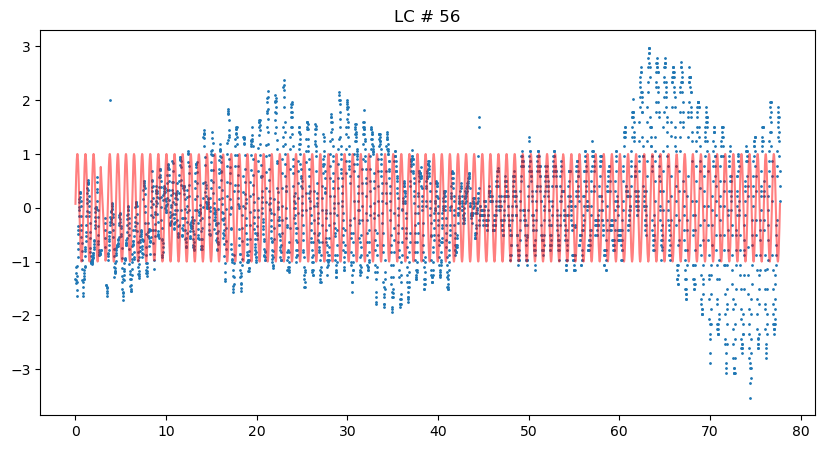

In [127]:
# Load the data
file_number = 56
data_dir = '../../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Find period of the light curve and convert from index to days (what x is in)
period = get_dom_period(y)
period = period * (x[-1] - x[0]) / len(x)
print(f"Dominant period: {period}")
sinusoid = np.sin(2 * np.pi * x / period)

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(x, y, '.', markersize=2)
plt.plot(x, sinusoid, 'r', alpha=0.5)
plt.title(f"LC # {file_number}")
plt.show()

Fit GP and get model parameters

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


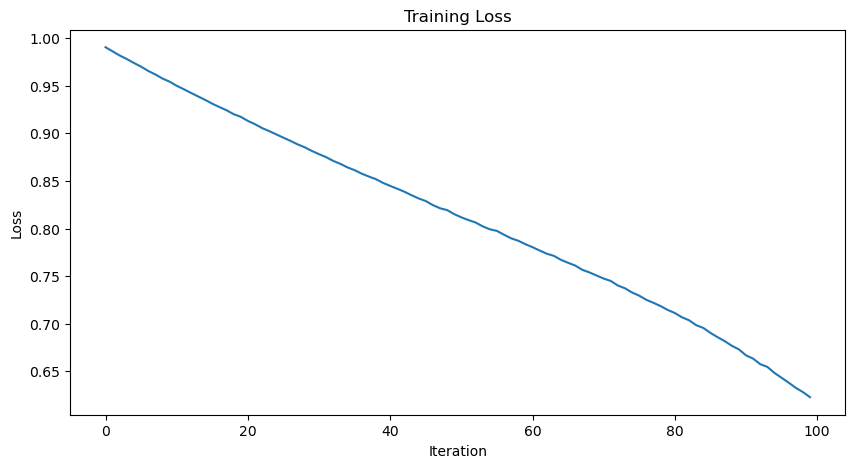

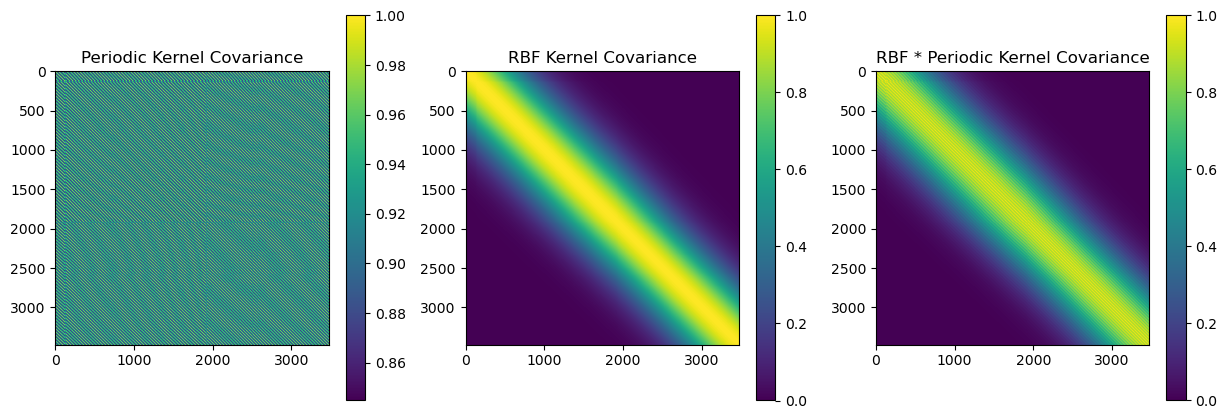

In [34]:
# Remove data between x = 30 and x = 50
x_new = x[(x < 30) | (x > 40)]
y_new = y[(x < 30) | (x > 40)]
y_err_new = y_err[(x < 30) | (x > 40)]

# Hyperparameters
training_iterations = 100
lr = 0.01
learn_additional_noise = True

kernel = QuasiPeriodicKernel(
    period_length_constraint=Interval(lower_bound=min(period - 0.01, 1.0), upper_bound=100.0, initial_value=period), 
    lengthscale_constraint=Interval(lower_bound=5.0, upper_bound=30.0)
)

# Train GP model
model, likelihood, mll = train_gp(
    torch.tensor(x_new, dtype=torch.float32).to(device),
    torch.tensor(y_new, dtype=torch.float32).to(device), 
    torch.tensor(y_err_new, dtype=torch.float32).to(device), 
    training_iterations=training_iterations, 
    lr=lr,
    device=device,
    learn_additional_noise=learn_additional_noise,
    kernel=kernel,
    plot=True
)

likelihood.second_noise_covar.raw_noise: -1.004801869392395
mean_module.raw_constant: 0.42528849840164185
covar_module.raw_outputscale: 0.9255691170692444
covar_module.base_kernel.periodic_kernel.raw_lengthscale: -0.9740740656852722
covar_module.base_kernel.periodic_kernel.raw_period_length: -9.799209594726562
covar_module.base_kernel.rbf_kernel.raw_lengthscale: -1.114335060119629

Learned GP parameters:
Mean Constant:  0.42528849840164185
Outputscale:  1.259399175643921
Additional Noise:  [0.3121725 0.3121725 0.3121725 ... 0.3121725 0.3121725 0.3121725]
Periodic Lengthscale:  11.851730346679688
Period Length:  0.8886994123458862
RBF Lengthscale:  11.176589965820312


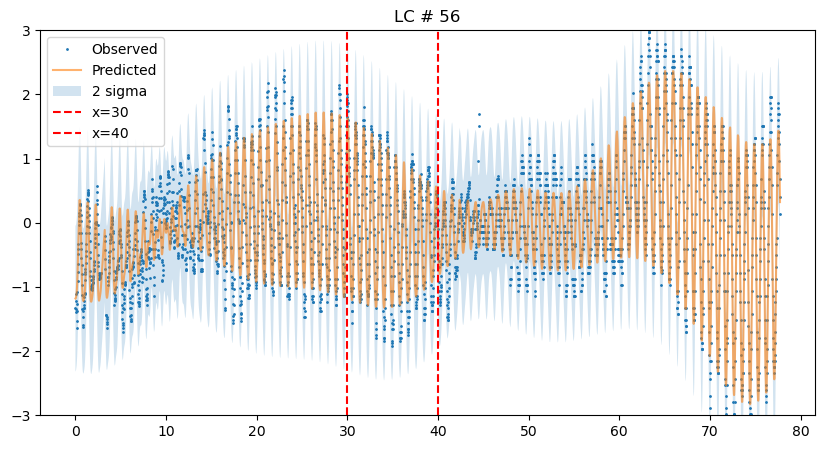

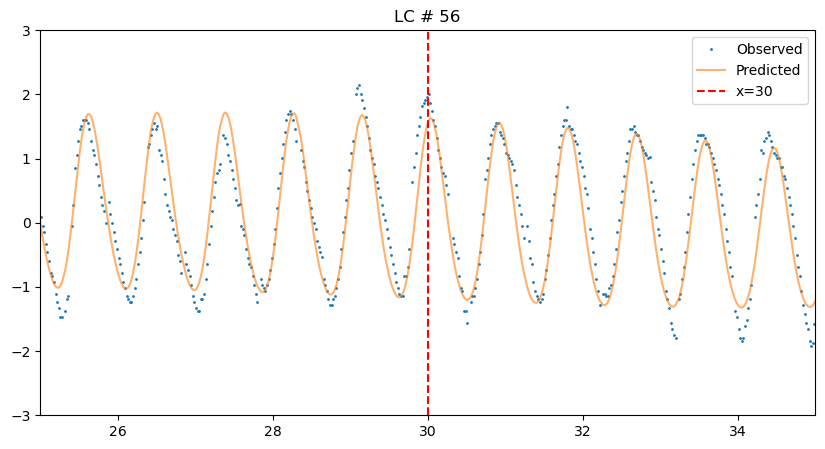

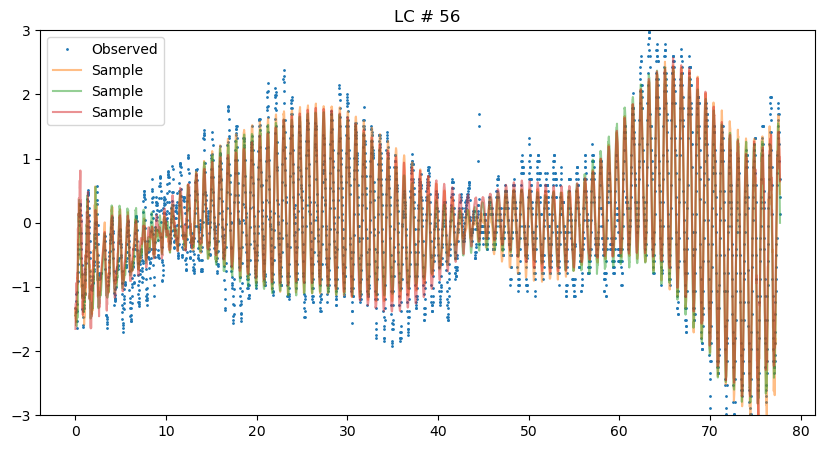

In [33]:
# Print learned GP parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.data.item()}")

noises = model.likelihood.noise.squeeze().detach().cpu().numpy()
outputscale = model.covar_module.outputscale.item()
mean_constant = model.mean_module.constant.item()

print("\nLearned GP parameters:")
print("Mean Constant: ", mean_constant)
print("Outputscale: ", outputscale)
print("Additional Noise: ", noises)

if isinstance(kernel, QuasiPeriodicKernel):
    period_length = model.covar_module.base_kernel.periodic_kernel.period_length.item()
    periodic_lengthscale = model.covar_module.base_kernel.periodic_kernel.lengthscale.item()
    lengthscale = model.covar_module.base_kernel.rbf_kernel.lengthscale.item()
    print("Periodic Lengthscale: ", periodic_lengthscale)
    print("Period Length: ", period_length)
    print("RBF Lengthscale: ", lengthscale)

elif isinstance(kernel, RBFKernel):
    lengthscale = model.covar_module.base_kernel.lengthscale.item()
    print("RBF Lengthscale: ", lengthscale)

elif isinstance(kernel, PeriodicKernel):
    period_length = model.covar_module.base_kernel.period_length.item()
    periodic_lengthscale = model.covar_module.base_kernel.lengthscale.item()
    print("Period Length: ", period_length)
    print("Periodic Lengthscale: ", periodic_lengthscale)

# Predict
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(torch.tensor(x, dtype=torch.float32).to(device)))
    samples = predictions.sample(sample_shape=torch.Size([3]))
    mean = predictions.mean.cpu().numpy()
    variance = predictions.variance.cpu().numpy()
    stddev = np.sqrt(variance)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, '.', markersize=2, label='Observed')
plt.plot(x, mean, label='Predicted', alpha=0.6)
plt.fill_between(x, mean - 2*stddev, mean + 2*stddev, alpha=0.2, label='2 sigma')
plt.axvline(30, color='r', linestyle='--', label=f'x=30')
plt.axvline(40, color='r', linestyle='--', label=f'x=40')
plt.ylim(-3, 3)
plt.legend()
plt.title(f"LC # {file_number}")

plt.figure(figsize=(10,5))
plt.plot(x, y, '.', markersize=2, label='Observed')
plt.plot(x, mean, label='Predicted', alpha=0.6)
plt.axvline(30, color='r', linestyle='--', label=f'x=30')
plt.xlim(25, 35)
plt.ylim(-3, 3)
plt.legend()
plt.title(f"LC # {file_number}")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(x, y, '.', markersize=2, label='Observed')
for i in range(3):
    plt.plot(x, samples[i].cpu().numpy(), alpha=0.5, label='Sample')
plt.ylim(-3, 3)
plt.legend()
plt.title(f"LC # {file_number}")
plt.show()

Number of high residuals: 15 with values [2.671326   1.29862615 2.05210171 1.88143706 1.19904511 1.29825196
 1.24041113 1.3125837  1.25014188 1.31836306 1.51139368 1.4888373
 1.27240694 1.33892844 1.22522853] and x values [ 3.80208333 44.44791667 44.46875    44.48958333 59.71875    59.73958333
 59.76041667 59.78125    59.80208333 59.82291667 59.84375    59.86458333
 59.88541667 59.90625    59.92708333]
cutoff_mean: 1.1247434616088867


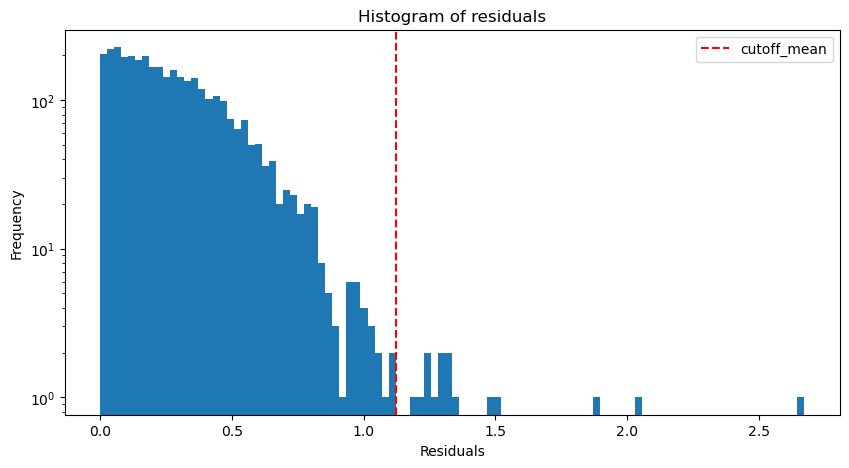

In [19]:
# Calculate residuals
residuals = np.abs((mean - y))
cutoff = 2*stddev
cutoff_mean = 2*np.mean(stddev)
high_residuals = residuals[residuals > cutoff]
print(f"Number of high residuals: {len(high_residuals)} with values {high_residuals} and x values {x[residuals > cutoff]}")
print(f"cutoff_mean: {cutoff_mean}")

# Plot histogram of residuals
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=100)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Histogram of residuals")
plt.axvline(x=cutoff_mean, color='r', linestyle='--', label=f'cutoff_mean')
plt.legend()
plt.show()

/tmp/ipykernel_2174916/2267464583.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_vars = torch.tensor(noises * 3000).to(device)


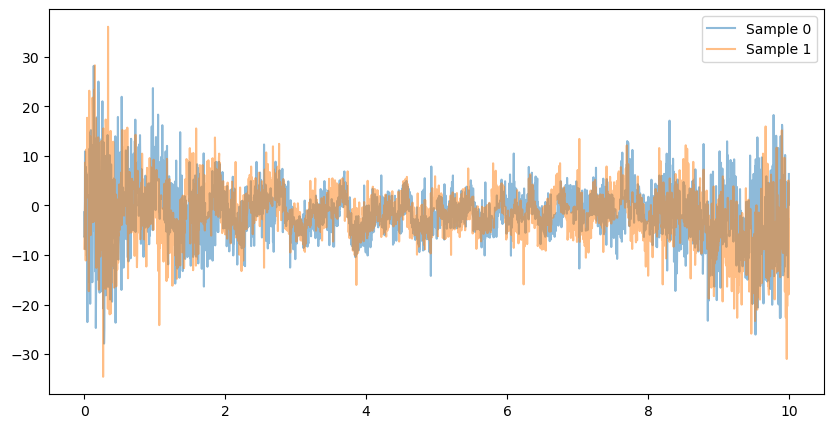

In [6]:
# Initialize new gp model with the following hyperparameters:
# Learned GP parameters:
# Mean Constant:  0.42528849840164185
# Outputscale:  1.259399175643921
# Additional Noise:  [0.3121725 0.3121725 0.3121725 ... 0.3121725 0.3121725 0.3121725]
# Periodic Lengthscale:  11.851730346679688
# Period Length:  0.8886994123458862
# RBF Lengthscale:  11.176589965820312
noises = torch.tensor([0.3121725] * 3000).to(device)
outputscale = 1.259399175643921
mean_constant = 0.42528849840164185
period_length = 0.8886994123458862
periodic_lengthscale = 11.851730346679688
rbf_lengthscale = 11.176589965820312

# Define timesteps, y as Gaussian noise, and noise
x = torch.linspace(0, 10, 3000).to(device)
noise_vars = torch.tensor(noises * 3000).to(device)

# Get GP model
kernel = ParameterizedQuasiPeriodicKernel(period_length, periodic_lengthscale, rbf_lengthscale).to(device)
model = ParameterizedGPModel(kernel, mean_constant, outputscale, noise_vars).to(device)

# Generate predictions
model.eval()
model.likelihood.eval()

# Sample from the GP
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model(x)
    samples = model.likelihood(model(x)).sample(sample_shape=torch.Size([2]))
    mean = predictions.mean.cpu().numpy()
    variance = predictions.variance.cpu().numpy()
    stddev = np.sqrt(variance)

# Plot
plt.figure(figsize=(10,5))
for i in range(2):
    plt.plot(x.cpu().numpy(), samples[i].cpu().numpy(), alpha=0.5, label=f'Sample {i}')
plt.legend()
plt.show()

## Create distribution over all 78 lightcurves

### Create list of GP learned parameters and high_residuals for each lightcurve

In [13]:
# Initialize lists
mean_constants = []
outputscales = []
periodic_lengthscales = []
period_lengths = []
rbf_lengthscales = []
noises = []
high_residuals = []

# Hyperparameters
training_iterations = 100
lr = 0.01
learn_additional_noise = True
residuals_cutoff = 2

# Load each file, train GP, append values to lists of GP parameters and tail distribution
for file_number in range(78):
    # Load the data
    data_dir = '../../data/k2/'
    filename = f'k2_{file_number}.fits'
    x, y, y_err = load_k2_data(data_dir + filename)

    # Scale data to be between 0 and 1
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    y_err = y_err / (np.max(y) - np.min(y))

    # Standardize data to have mean 0 and std of 1
    mean_y = np.mean(y)
    std_y = np.std(y)
    y = (y - mean_y) / std_y
    y_err = y_err / std_y

    # Get dominant period to be initial period_length value
    period = get_dom_period(y)
    period = period * (x[-1] - x[0]) / len(x)
    
    kernel = QuasiPeriodicKernel(
        period_length_constraint=GreaterThan(lower_bound=min(period - 0.1, 1.0), initial_value=period), 
        lengthscale_constraint=Interval(lower_bound=5.0, upper_bound=30.0)
    )

    # Train GP model
    model, likelihood, mll = train_gp(
        torch.tensor(x_new, dtype=torch.float32).to(device),
        torch.tensor(y_new, dtype=torch.float32).to(device), 
        torch.tensor(y_err_new, dtype=torch.float32).to(device), 
        training_iterations=training_iterations, 
        lr=lr,
        device=device,
        learn_additional_noise=learn_additional_noise,
        kernel=kernel,
        plot=False
    )

    # Evaluate model and append high residuals to list
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(torch.tensor(x, dtype=torch.float32).to(device)))
        mean = predictions.mean.cpu().numpy()
        variance = predictions.variance.cpu().numpy()
        stddev = np.sqrt(variance)

    residuals = np.abs((mean - y))
    curr_high_residuals = residuals[residuals > residuals_cutoff * stddev]
    high_residuals.extend(curr_high_residuals)

    # Append GP parameters to lists
    mean_constants.append(model.mean_module.constant.item())
    outputscales.append(model.covar_module.outputscale.item())
    periodic_lengthscales.append(model.covar_module.base_kernel.periodic_kernel.lengthscale.item())
    period_lengths.append(model.covar_module.base_kernel.periodic_kernel.period_length.item())
    rbf_lengthscales.append(model.covar_module.base_kernel.rbf_kernel.lengthscale.item())
    noises.append(np.mean(model.likelihood.noise.squeeze().detach().cpu().numpy()))

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:189: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


78 78 78 78 78 78 6627
1.9659758881730685 58.86655482309635


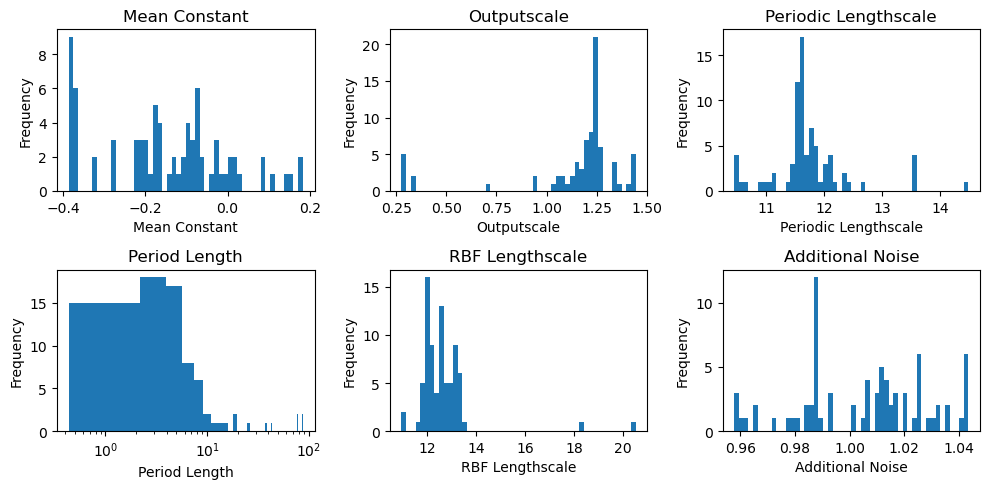

Text(0.5, 1.0, 'High Residuals')

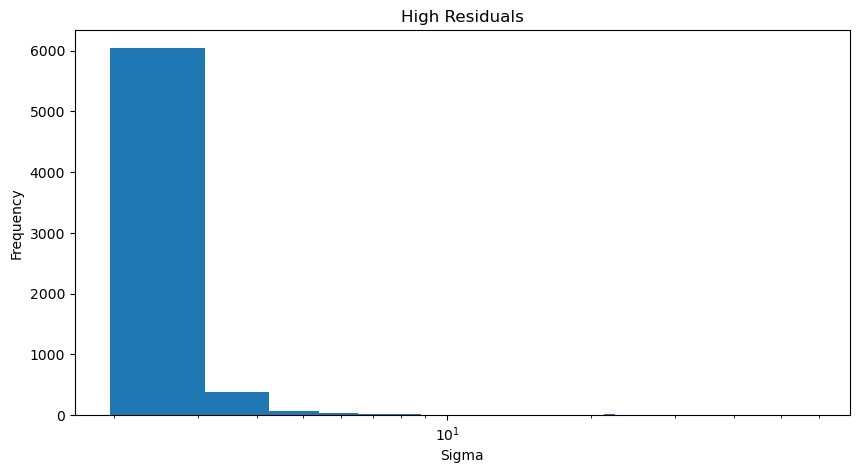

In [21]:
# Check all lists have the same length
print(len(mean_constants), len(outputscales), len(periodic_lengthscales), len(period_lengths), len(rbf_lengthscales), len(noises), len(high_residuals))
print(min(high_residuals), max(high_residuals))

# Plot parameters all in one plot, separate subplots for each parameter
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
plt.hist(mean_constants, bins=50)
plt.xlabel("Mean Constant")
plt.ylabel("Frequency")
plt.title("Mean Constant")

plt.subplot(2,3,2)
plt.hist(outputscales, bins=50)
plt.xlabel("Outputscale")
plt.ylabel("Frequency")
plt.title("Outputscale")

plt.subplot(2,3,3)
plt.hist(periodic_lengthscales, bins=50)
plt.xlabel("Periodic Lengthscale")
plt.ylabel("Frequency")
plt.title("Periodic Lengthscale")

plt.subplot(2,3,4)
plt.hist(period_lengths, bins=50)
plt.xlabel("Period Length")
plt.ylabel("Frequency")
plt.xscale('log')
plt.title("Period Length")

plt.subplot(2,3,5)
plt.hist(rbf_lengthscales, bins=50)
plt.xlabel("RBF Lengthscale")
plt.ylabel("Frequency")
plt.title("RBF Lengthscale")

plt.subplot(2,3,6)
plt.hist(noises, bins=50)
plt.xlabel("Additional Noise")
plt.ylabel("Frequency")
plt.title("Additional Noise")

plt.tight_layout()
plt.show()

# Plot histogram of high residuals
plt.figure(figsize=(10,5))
plt.hist(high_residuals, bins=50)
plt.xlabel("Sigma")
plt.ylabel("Frequency")
plt.xscale('log')
plt.title("High Residuals")

### Write them to a file

In [22]:
# # Write GP parameters and high_residuals to file in data folder as a csv with column names
# save_dir = '../../data/synthetic_params/'
# with open(save_dir + 'gp_parameters.csv', mode='w') as file:
#     writer = csv.writer(file)
#     writer.writerow(['file_number', 'mean_constant', 'outputscale', 'periodic_lengthscale', 'period_length', 'rbf_lengthscale', 'noise'])
#     for i in range(len(mean_constants)):
#         writer.writerow([i, mean_constants[i], outputscales[i], periodic_lengthscales[i], period_lengths[i], rbf_lengthscales[i], noises[i]])

# with open(save_dir + 'high_residuals.csv', mode='w') as file:
#     writer = csv.writer(file)
#     writer.writerow(['high_residual'])
#     for i in range(len(high_residuals)):
#         writer.writerow([high_residuals[i]])

### Read parameters and generate a sample from distribution over parameters

In [57]:
# Function to fit a distribution and return parameters
def fit_best_distribution(
        data, 
        bins=100,
        dist_names=None,
        plot=False
    ):

    if dist_names is None:
        dist_names = ['norm', 'expon', 'lognorm', 'gamma', 'beta', 'uniform']
    
    best_fit_name = None
    best_fit_params = None
    best_sse = np.inf  # Smallest sum of squared errors

    # Histogram for calculating density
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins

    for dist_name in dist_names:
        try:
            dist = getattr(scipy.stats, dist_name)
            params = dist.fit(data)  # Fit the distribution
            pdf = dist.pdf(bin_centers, *params)
            sse = np.sum((hist - pdf) ** 2)
            
            if sse < best_sse:
                best_fit_name = dist_name
                best_fit_params = params
                best_sse = sse
        except Exception as e:
            print(f"Error fitting {dist_name}: {e}")

    if plot:
        plt.figure(figsize=(10,5))
        plt.hist(data, bins=bins, density=True, alpha=0.6)
        x = np.linspace(min(data), max(data), 1000)
        pdf = getattr(scipy.stats, best_fit_name).pdf(x, *best_fit_params)
        plt.plot(x, pdf, 'r', lw=2)
        plt.ylim(0, min(max(pdf), 30))
        plt.title(f"Best fit distribution: {best_fit_name}")
        plt.show()
    
    return best_fit_name, best_fit_params

# Function to sample from fitted distributions
def sample_from_distributions(
        data_dict,
        distribution_dict = None,
        ):
    
    samples = {}
    for key, values in data_dict.items():
        # Fit the distribution to the parameter
        if distribution_dict is not None and key in distribution_dict:
            dist_name, params = distribution_dict[key]
            dist = getattr(scipy.stats, dist_name)
        else:
            dist_name, params = fit_best_distribution(values)
            dist = getattr(scipy.stats, dist_name)
        
        # Sample new values
        samples[key] = dist.rvs(*params, size=1)
    return samples

# Function to sample high_residuals
def sample_high_residuals_random_signs(
        high_residuals, 
        num_lightcurves,
        distribution_dict=None,
    ):
    # Fit the best distribution to high residuals
    if distribution_dict is not None and 'high_residuals' in distribution_dict:
        dist_name, params = distribution_dict['high_residuals']
        dist = getattr(scipy.stats, dist_name)
    else:
        dist_name, params = fit_best_distribution(high_residuals)
        dist = getattr(scipy.stats, dist_name)

    # Decide a reasonable number of residuals to generate based on how many residuals were distributed among the lightcurves
    avg_num_residuals = len(high_residuals) / (num_lightcurves * 10)
    num_residuals = np.random.poisson(avg_num_residuals, size=None)

    # Sample total residuals
    residuals = dist.rvs(*params, size=num_residuals)
    
    # Randomly flip signs with 33% probability
    signs = np.random.choice([1, 1, -1], size=num_residuals)
    residuals *= signs
    
    return np.array(residuals)

### Fit distributions and write to files

78 78 78 78 78 78 6627
Fitting distribution for mean_constants


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


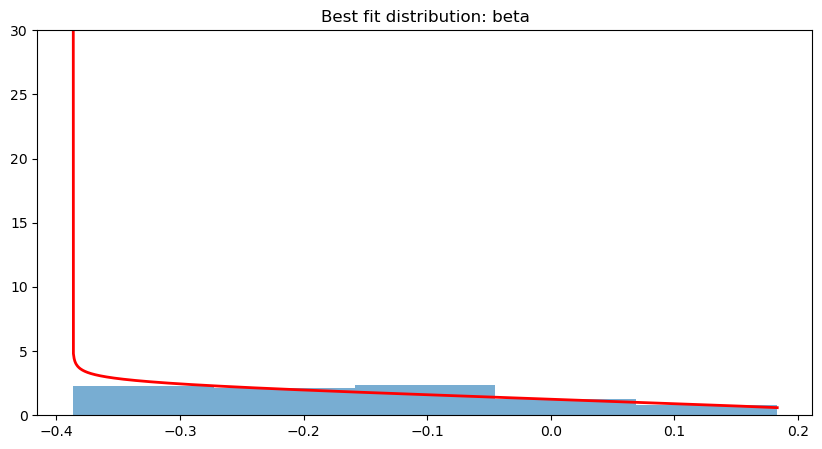

Fitting distribution for outputscales


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


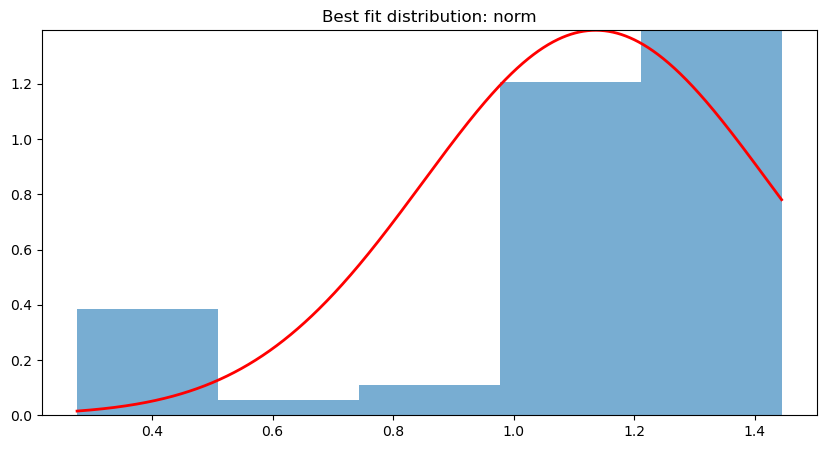

Fitting distribution for periodic_lengthscales


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


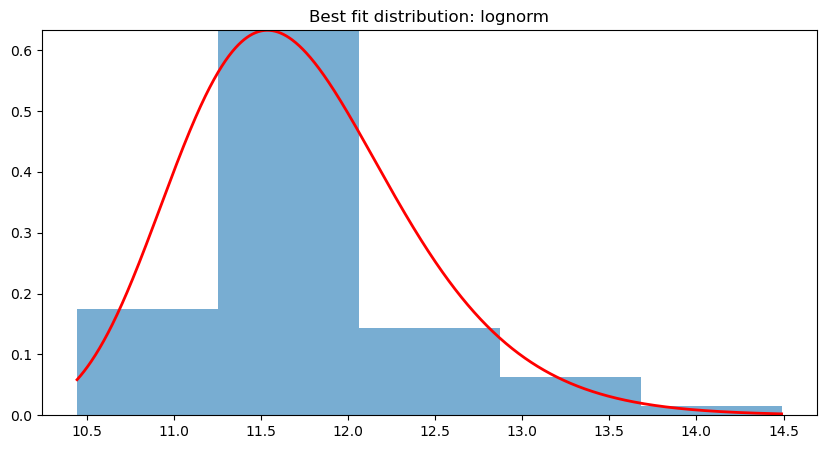

Fitting distribution for period_lengths


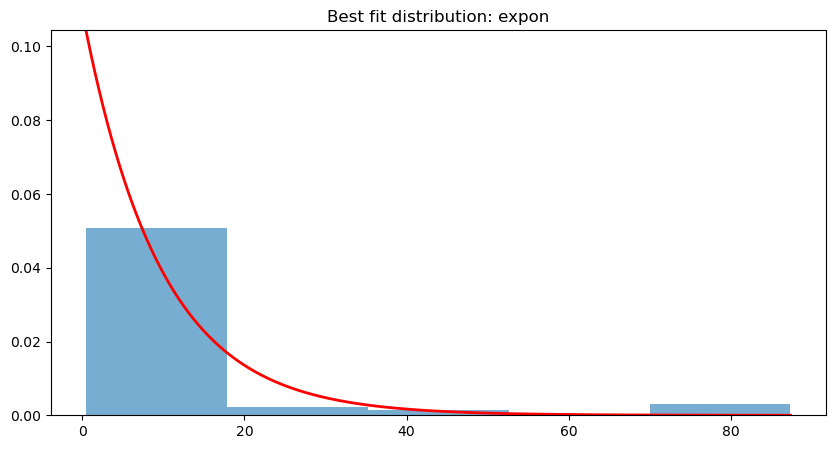

Fitting distribution for rbf_lengthscales


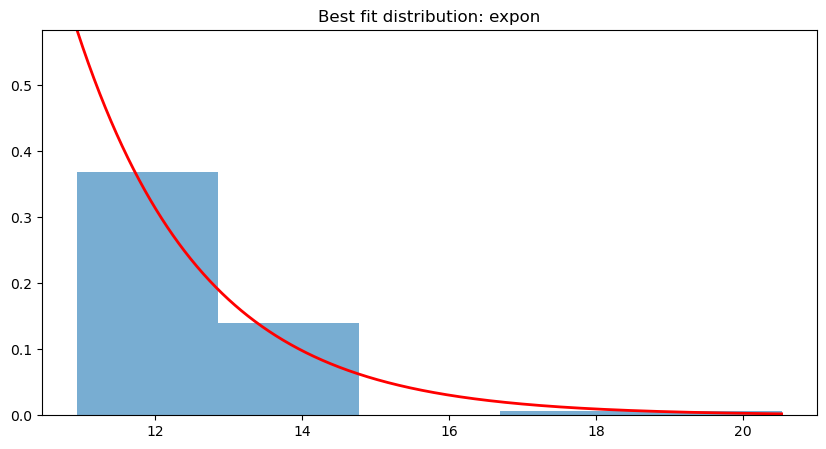

Fitting distribution for noises


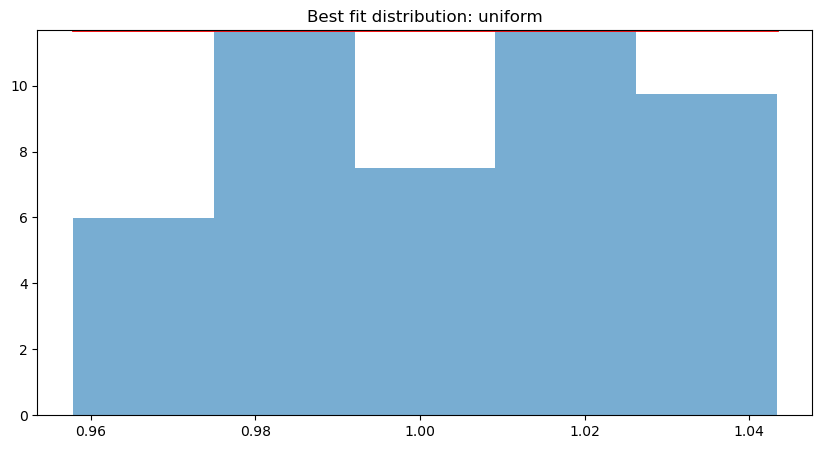

Fitting distribution for high_residuals


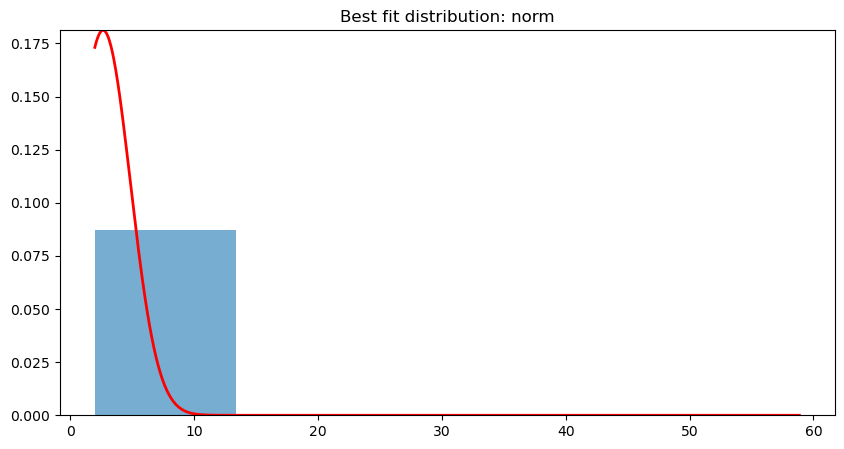

{'mean_constants': ('beta', (0.8847564046346952, 1.6867240249853546, -0.38672843575477606, 0.671994829063512)), 'outputscales': ('norm', (1.136054631609183, 0.2861857116732809)), 'periodic_lengthscales': ('lognorm', (0.2006918584306103, 8.458347451532124, 3.206432460714306)), 'period_lengths': ('expon', (0.4355210065841675, 9.58046551545461)), 'rbf_lengthscales': ('expon', (10.939048767089844, 1.715589339916523)), 'noises': ('uniform', (0.95778936, 0.08563403999999997)), 'high_residuals': ('norm', (2.6294620074628834, 2.20183618370102))}


In [58]:
# Read GP parameters and high_residuals from files
mean_constants = []
outputscales = []
periodic_lengthscales = []
period_lengths = []
rbf_lengthscales = []
noises = []
high_residuals = []

save_dir = '../../data/synthetic_params/'

with open(save_dir + 'gp_parameters.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        mean_constants.append(float(row[1]))
        outputscales.append(float(row[2]))
        periodic_lengthscales.append(float(row[3]))
        period_lengths.append(float(row[4]))
        rbf_lengthscales.append(float(row[5]))
        noises.append(float(row[6]))

with open(save_dir + 'high_residuals.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        high_residuals.append(float(row[0]))

print(len(mean_constants), len(outputscales), len(periodic_lengthscales), len(period_lengths), len(rbf_lengthscales), len(noises), len(high_residuals))

# Write parameters and their distributions to a file
parameters = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'period_lengths': period_lengths,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises,
    'high_residuals': high_residuals
}

dists = {}
for key, values in parameters.items():
    # Fit the distribution
    print(f"Fitting distribution for {key}")
    dist_name, params = fit_best_distribution(values, bins=5, plot=True)
    dists[key] = (dist_name, params)

print(dists)
with open(save_dir + 'fitted_distributions.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['parameter', 'distribution', 'params'])
    for key, value in dists.items():
        writer.writerow([key, value[0], value[1]])

### Load distributions from file and generate a sample

In [59]:
# Create data dictionary with loaded parameters
data_dict = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'period_lengths': period_lengths,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises
}

# Load distributions from file
load_dists = {}
with open(save_dir + 'fitted_distributions.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[0] == 'parameter':
            continue

        key = row[0]
        dist_name = row[1]
        params = tuple(map(float, row[2].strip('()').split(',')))

        load_dists[key] = (dist_name, params)

# Fit distributions and sample
sampled_data = sample_from_distributions(
    data_dict,
    load_dists
)

# Get residuals
sampled_residuals = sample_high_residuals_random_signs(
    high_residuals, 
    78,
    load_dists
)

print(sampled_data)
print(sampled_residuals)

{'mean_constants': array([-0.2469783]), 'outputscales': array([1.82906706]), 'periodic_lengthscales': array([11.54038192]), 'period_lengths': array([9.40607487]), 'rbf_lengthscales': array([12.08363869]), 'noises': array([0.97563934])}
[-0.09580105  4.53722101 -3.00473823 -3.53714234 -4.16437931  1.2643484
 -6.2266445   1.90876901  5.02176975 -2.34436812]


### Generate lightcurve

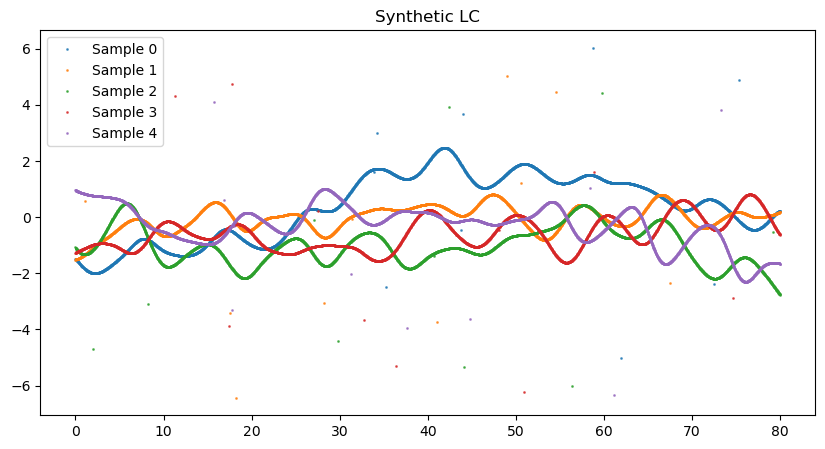

In [60]:
num_timesteps=3500
num_samples=5

# Define timesteps, y as Gaussian noise, and noise
x = torch.linspace(0, 80, num_timesteps).to(device)
noise_vars = torch.tensor([sampled_data["noises"]] * num_timesteps).to(device)

# Get GP model
kernel = ParameterizedQuasiPeriodicKernel(
    period_length=sampled_data["period_lengths"], 
    periodic_lengthscale=sampled_data["periodic_lengthscales"], 
    rbf_lengthscale=sampled_data["rbf_lengthscales"]
).to(device)

model = ParameterizedGPModel(
    kernel, 
    mean_constant=sampled_data["mean_constants"], 
    outputscale=sampled_data["outputscales"], 
    noise_vars=noise_vars
).to(device)

# Generate predictions
model.eval()
model.likelihood.eval()

with torch.no_grad():
    # Generate the GP predictions
    predictions = model.likelihood(model(x))
    samples = predictions.sample(torch.Size([num_samples]))
    mean = predictions.mean.cpu().numpy()

# Convert to numpy for further processing
x = x.detach().cpu().numpy()
samples = samples.detach().cpu().numpy()
for i in range(num_samples):
    # Add some high residuals randomly distributed
    num_high_residuals = len(sampled_residuals)
    high_residual_indices = np.random.choice(num_timesteps, num_high_residuals, replace=False)
    for j, idx in enumerate(high_residual_indices):
        samples[i, idx] += sampled_residuals[j]

plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.plot(x, samples[i], '.', ms=2, alpha=0.7, label=f'Sample {i}')
plt.legend()
plt.title("Synthetic LC")
plt.show()

### Generate many samples from different lightcurves

{'mean_constants': array([-0.30925452]), 'outputscales': array([1.37542394]), 'periodic_lengthscales': array([11.90166683]), 'period_lengths': array([23.81834642]), 'rbf_lengthscales': array([11.22154007]), 'noises': array([1.01419067])}
[-2.45504038  1.25800092 -1.38499844  1.5290974  -1.66331059  2.84517182
  1.91183365  1.11290456]
{'mean_constants': array([-0.38120163]), 'outputscales': array([1.01491437]), 'periodic_lengthscales': array([12.10992749]), 'period_lengths': array([7.45772572]), 'rbf_lengthscales': array([12.805146]), 'noises': array([0.96555641])}
[4.58522242 0.85768728 4.50248529 1.32400812 3.61808109 3.8184705 ]
{'mean_constants': array([-0.21087603]), 'outputscales': array([0.81942643]), 'periodic_lengthscales': array([11.13437813]), 'period_lengths': array([6.96884712]), 'rbf_lengthscales': array([11.48652926]), 'noises': array([0.96702975])}
[-1.9183878  -3.5887231  -3.29249834  0.85056887  4.94114399  2.31773941
 -0.89411873 -0.37379023  4.4084022  -0.23661136 -

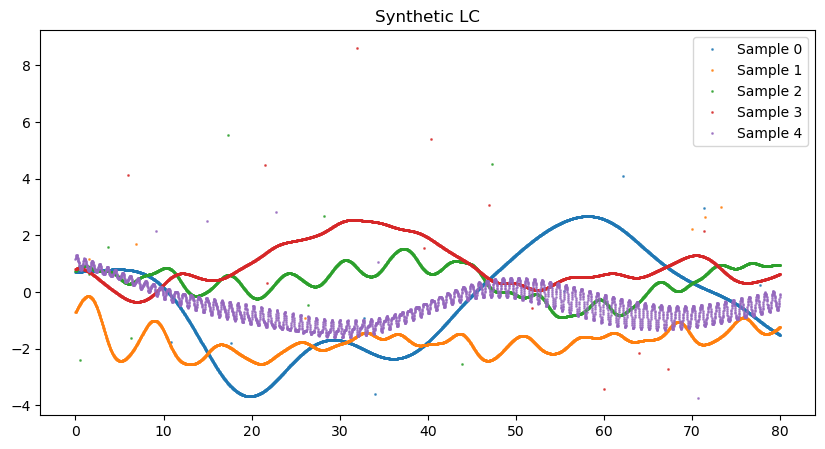

In [61]:
num_timesteps = 3500
num_samples = 5
lc_samples = []

# Create data dictionary with loaded parameters
data_dict = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'period_lengths': period_lengths,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises
}

# Load distributions from file
load_dists = {}
with open(save_dir + 'fitted_distributions.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[0] == 'parameter':
            continue

        key = row[0]
        dist_name = row[1]
        params = tuple(map(float, row[2].strip('()').split(',')))

        load_dists[key] = (dist_name, params)

for i in range(num_samples):
    # Fit distributions and sample
    sampled_data = sample_from_distributions(
        data_dict,
        load_dists
    )

    # Get residuals
    sampled_residuals = sample_high_residuals_random_signs(
        high_residuals, 
        78,
        load_dists
    )

    print(sampled_data)
    print(sampled_residuals)

    # Define timesteps, y as Gaussian noise, and noise
    x = torch.linspace(0, 80, num_timesteps).to(device)
    noise_vars = torch.tensor([sampled_data["noises"]] * num_timesteps).to(device)

    # Get GP model
    kernel = ParameterizedQuasiPeriodicKernel(
        period_length=sampled_data["period_lengths"], 
        periodic_lengthscale=sampled_data["periodic_lengthscales"], 
        rbf_lengthscale=sampled_data["rbf_lengthscales"]
    ).to(device)

    model = ParameterizedGPModel(
        kernel, 
        mean_constant=sampled_data["mean_constants"], 
        outputscale=sampled_data["outputscales"], 
        noise_vars=noise_vars
    ).to(device)

    # Generate predictions
    model.eval()
    model.likelihood.eval()

    with torch.no_grad():
        # Generate the GP predictions
        predictions = model.likelihood(model(x))
        samples = predictions.sample(torch.Size([1]))
        mean = predictions.mean.cpu().numpy()

    # Convert to numpy for further processing
    x = x.detach().cpu().numpy()
    samples = samples.detach().cpu().numpy()
    for i in range(1):
        # Add some high residuals randomly distributed
        num_high_residuals = len(sampled_residuals)
        high_residual_indices = np.random.choice(num_timesteps, num_high_residuals, replace=False)
        for j, idx in enumerate(high_residual_indices):
            samples[i, idx] += sampled_residuals[j]

    lc_samples.append(samples[0])

plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.plot(x, lc_samples[i], '.', ms=2, alpha=0.7, label=f'Sample {i}')
plt.legend()
plt.title("Synthetic LC")
plt.show()